# Introduction to Neural Networks 

editted by Yuki Saito at 2021.01.18

#### ニューラルネットワークの基本モデルとして，まず初めに単層ニューラルネット(隠れ層が１層もないネットワーク)を以下で紹介します．

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

#### データセット読み込み(64*64解像度のRGB画像209枚)

In [69]:
def load_dataset():
    train_dataset = h5py.File('dataset/train_catvnoncat.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) 
    train_y = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File('dataset/test_catvnoncat.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:]) 
    test_y = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

train_x, train_y, test_x, test_y, classes=load_dataset()

#### Visualize data

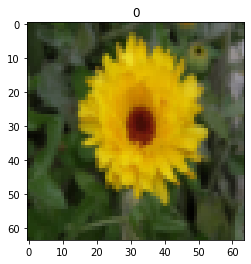

Train X shape: (209, 64, 64, 3)


In [70]:
# run several times to visualize different data points
# the title shows the ground truth class labels (0=no cat , 1 = cat)
index = np.random.randint(low=0,high=train_y.shape[1])
plt.imshow(train_x[index])
plt.title(str(train_y[0,index]))
plt.show()
print ("Train X shape: " + str(train_x.shape))

#### 前処理
ニューラルネットワークの入力はn×1のベクトル形式なので，入力画像(64*64*3)をFlattenして１列のベクトルへと変換します．また，Loss関数の値を小さくし，ネットワークの学習効率を上げるために画像の画素値(0~255)を0~1の範囲に正規化しておきます．

In [71]:

train_x = train_x.reshape(train_x.shape[0], -1).T
#val_x = val_x.reshape(val_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T



print ("Train X shape: " + str(train_x.shape))
print ("Train Y shape: " + str(train_y.shape))
#print ("Val X shape: " + str(val_x.shape))
#print ("Val Y shape: " + str(val_y.shape))
print ("Test X shape: " + str(test_x.shape))
print ("Test Y shape: " + str(test_y.shape))

Train X shape: (12288, 209)
Train Y shape: (1, 209)
Test X shape: (12288, 50)
Test Y shape: (1, 50)


In [72]:
train_x = train_x/255.
test_x = test_x/255.


### 1. 単層ニューラルネットワークを用いた分類タスク(Classification)


**a) 以下の３関数はニューラルネットの学習に不可欠な要素を示しています:
- **initialize_parameters** 
ネットワークのパラメータをランダム初期化するコード．ネットワークの重みをランダムで初期化しないと，中間層で全てのニューロン(ユニット)の結果が同じになってしまうため，ニューラルネットは学習が進みません．(「対称性」を破るためにランダム初期化する)


-  **sigmoid**
活性化関数(Activation Function)として非線形関数であるシグモイド関数を利用しています．非線形関数を用いないと，ニューラルネットは隠れ層の意味がなくなってしまい，１層のニューラルネットと変わらないモデルしか表現できません．

Ex)３層ニューラルネットを考える．ネットワークの出力をh(x)で表現するとし，活性化関数をaxと線形で表現します．すると，feed fowardの結果は
 y(x)=h(h(h(x)))となり,これは y(x)=kx (k=a^3) と同じ結果になってしまいます．


- **neuron** 
重みWを入力に対して乗算して，bias項を足し合わせる関数です．(W.Tx+b)

In [73]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [74]:
def initialize_parameters(dim):
    init_w = 0.1
    init_b = 1
    w = init_w * np.random.randn(dim, 1)
    b = init_b * np.random.randn(1)
    return w, b

In [75]:
def neuron(w,b,X):
    pred_y = np.matmul(w.T, X) + b
    return pred_y

**b)** **Forward Pass:**
まず，ネットワークの出力をKさんするFeedFoward(順伝搬)を行います．単層ニューラルネットワークなので以下の方程式で計算されます．
 
 \begin{align}
 Y_{\rm pred}=\sigma(w^\top X+b) = [y_{\rm pred}^{(1)},y_{\rm pred}^{(2)},\dots,y_{\rm pred}^{(m)}]
 \end{align}
 

In [76]:
w, b = initialize_parameters(train_x.shape[0])
pred_y = sigmoid(neuron(w, b, train_x))
print(pred_y.shape)
print(w.shape)

(1, 209)
(12288, 1)


**c) 損失関数(Loss関数):**
 
ネットワークの出力(0~1)を入力画像があるクラスに属する確率と捉え，Binary Cross entropy Lossを用います.
Binary Cross Entropy を用いることは対数尤度関数を最大化することに等しい意味があります．
 \begin{align}
 E = - \frac{1}{m} \sum_{i=1}^m 
 y^{(i)} \log(y_{\rm pred}^{(i)}) +
 (1-y^{(i)}) \log(1-y_{\rm pred}^{(i)})
 \end{align}

In [77]:

def crossentropy(Y,Ypred):
    delta = 1e-10
    cost = -np.sum(Y * np.log(Ypred + delta) + (1-Y) * np.log((1-Ypred) + delta))/ Y.shape[1]
    return cost

crossentropy(train_y,pred_y)

4.840657049671921

**d) Back propagation:**

初期化->feed foward->Lossの計算と終えたら，最後にネットワークのパラメータを更新していきます．この更新をback propagationと呼びます．ニューラルネットワークの最大の特徴の１つで，微分のChain Rule(連鎖律)を用いてどんどん前の層へとパラメータの更新をかけていきます．


\begin{align}
\frac{\partial E}{\partial w} = & \frac{1}{m} X(Y_{\rm pred}-Y)^T\\
\frac{\partial E}{\partial b} = & \frac{1}{m} (Y_{\rm pred}-Y)\\
\end{align}

See a demonstration in the wikipedia page 
https://en.wikipedia.org/wiki/Cross_entropy

In [78]:
def backpropagate(X, Y, Ypred):
    m = X.shape[1]
    
    #find gradient (back propagation)
    dw = (1/m) * np.dot(X ,(Ypred-Y).T)
    db = (1/m) * np.sum(Ypred-Y)
    grads = {"dw": dw,
             "db": db} 
    
    return grads



**e) Optimization**
    BackPropagationではパラメータの微分値が上の計算で求まったら，Optimizationアルゴリズムを用いてLoss関数が最小になるようなパラメータを探索します．様々なOptimizationアルゴリズムがありますが，今回は一番単純なGradient Descent(最急降下法)を用います．

In [79]:
def gradient_descent(X, Y, iterations, learning_rate):    
    costs = []
    w, b = initialize_parameters(train_x.shape[0])
    
    for i in range(iterations):
        Ypred = sigmoid(neuron(w, b, X))
        cost = crossentropy(Y,Ypred)
        grads= backpropagate(X, Y, Ypred)
        
        #update parameters
        w = w - learning_rate * grads["dw"]
        b = b - learning_rate * grads["db"]
        costs.append(cost)
        
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
       
    return w,b, costs

w, b, costs = gradient_descent(train_x,train_y,iterations=3000, learning_rate = 0.001)


Cost after iteration 0: 1.190808
Cost after iteration 100: 0.906548
Cost after iteration 200: 0.798593
Cost after iteration 300: 0.730884
Cost after iteration 400: 0.679889
Cost after iteration 500: 0.638731
Cost after iteration 600: 0.604460
Cost after iteration 700: 0.575336
Cost after iteration 800: 0.550134
Cost after iteration 900: 0.527956
Cost after iteration 1000: 0.508146
Cost after iteration 1100: 0.490230
Cost after iteration 1200: 0.473864
Cost after iteration 1300: 0.458793
Cost after iteration 1400: 0.444826
Cost after iteration 1500: 0.431816
Cost after iteration 1600: 0.419649
Cost after iteration 1700: 0.408233
Cost after iteration 1800: 0.397490
Cost after iteration 1900: 0.387357
Cost after iteration 2000: 0.377780
Cost after iteration 2100: 0.368709
Cost after iteration 2200: 0.360105
Cost after iteration 2300: 0.351930
Cost after iteration 2400: 0.344151
Cost after iteration 2500: 0.336740
Cost after iteration 2600: 0.329670
Cost after iteration 2700: 0.322917
Cost

**e) Plot the training curve**
学習時のコスト関数の推移を可視化します．

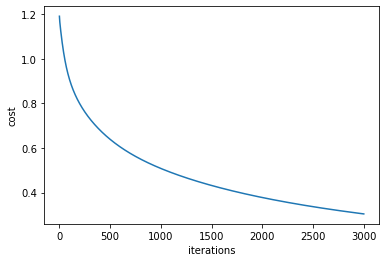

In [80]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

**f) Prediction**
testデータに対するpredictionを行い，training時のAccuracyとtest時のAcuuracyを計算します．

In [82]:
def predict(w, b, X):    
    y_pred = np.where(sigmoid(neuron(w, b, X)) <= 0.5, 0, 1)
    print(y_pred)
    return y_pred

# predict 
train_pred_y = predict(w, b, train_x)
test_pred_y = predict(w, b, test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))
    

[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1
  0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1
  1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0
  0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0]]
[[1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0
  1 1 0 0 1 1 0 0 1 0 1 1 1 0]]
Train Acc: 90.43062200956938 %
Test Acc: 60.0 %
